In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr,spearmanr,kendalltau,rankdata
from scipy.stats import *
from pylab import rcParams
import os
from sklearn.cluster import AgglomerativeClustering
from datetime import date
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
import random
import warnings
warnings.filterwarnings('ignore')

data_path = '../../data/'

# Data load

In [29]:
sample_annot = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='a')
patient_cancertype = {row['Sample ID']:row['Cancer type'] for row in sample_annot.to_dict(orient='records')}
enrichment = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='c')
wes = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='d')
cd8 = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='e')
fc = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='f')
exp = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='b').rename(columns={x:x.split('_')[0] for x in exp.columns})

In [3]:
cancer_type_colors = {
     'BrM:LUSC':'#245096',
     'BrM:BRCA':"#A55AAB",
     'BrM:HNSC':'#8a152e',
     'BrM:ESCA':'#936939',
     'BrM:URO':'#000000',
     'BrM:SCLC':'#5bc2b2',
     'BrM:LUAD':"#A3C2F4",
     'BrM:SKCM':"#3A9D58" }
   
number_of_colors = len(sample_annot['Sample ID'].tolist())
sample_colors = {list(sample_annot['Sample ID'].tolist())[i]:"#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)}

### Cohort sumarry per primary of origin

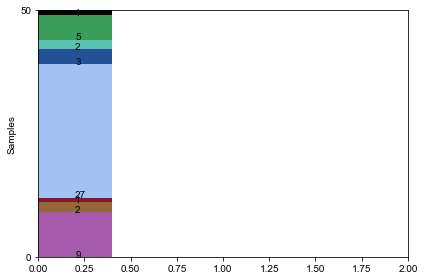

In [4]:
patient_cancertypeCount = {cancertype:len(cancertypedf) for cancertype,cancertypedf in sample_annot.groupby('Cancer type')}
bot = 0
for cancertype,countct in patient_cancertypeCount.items():
    plt.bar(0,countct,bottom=bot,color=cancer_type_colors[cancertype])
    plt.text(0.2,bot,str(countct))
    bot+=countct
plt.ylim(0,bot)
plt.yticks([0,bot],[0,bot])
plt.ylabel('Samples')
plt.xlim(0,2)
plt.tight_layout()
plt.show()

# PanCancer Immune Nanostring panel analyses

### PanCancer Immune Nanostring panel: enrichment score clustering

In [24]:
enrichment_heat = enrichment[['Sample ID','Cyt lymphocytes','DC', 'Naïve Tcells', 'Neutrophil', 'Bcells', 'Treg', 'TAM']].set_index('Sample ID').T
enrichment_IFNg = enrichment[['Sample ID','IFNgamma signature']].set_index('Sample ID')

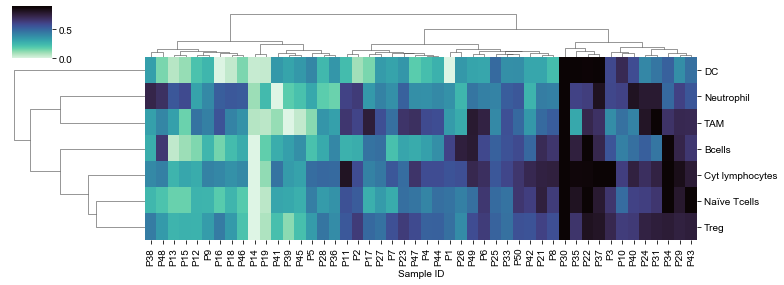

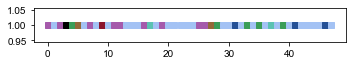

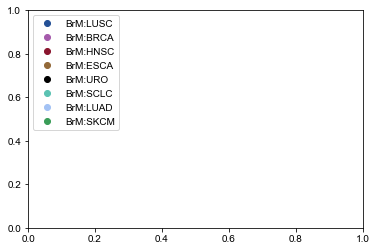

In [26]:
g = sns.clustermap(enrichment_heat, col_cluster=True, 
                       cmap="mako_r",vmin=0,vmax=0.9,
                       method='ward',figsize=(11, 4),xticklabels=True)

samples_order = []
for t in g.ax_heatmap.get_xticklabels():
    tst = t.get_text().split(':')[0]
    samples_order.append(tst)
plt.show()

ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(enrichment_heat.T)
sample_clust = {s: ward.labels_[i]
                for i, s in enumerate(enrichment_heat.T.index.tolist())}

ren_clust = {0:'low',1:'high',2:'intermediate'}
sample_clustNAME = {s:ren_clust[c] for s,c in sample_clust.items()}

fig = plt.figure(figsize=(5, 1))
for i in range(0, len(samples_order)):
    if samples_order[i] in patient_cancertype:
        plt.plot(i, 1, color=cancer_type_colors[patient_cancertype[samples_order[i]]], marker='s')
plt.tight_layout()
plt.show()

markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in cancer_type_colors.values()]
plt.legend(markers, cancer_type_colors.keys(), numpoints=1,loc='upper left')
plt.show()

### PanCancer Immune Nanostring panel: IFNgamma signature analysis

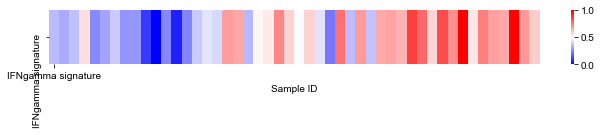

T-test results: low vs intermediate Ttest_indResult(statistic=-5.257591220155895, pvalue=7.953646488383299e-06)
T-test results: intermediate vs high Ttest_indResult(statistic=-2.797032940563176, pvalue=0.009063410489064058)
T-test results: low vs intermediate+high Ttest_indResult(statistic=-6.7323675171698945, pvalue=2.298583757469047e-08)


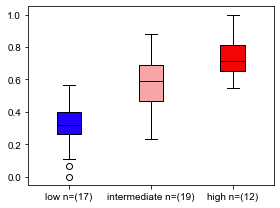

Pearson correlation results: IFNgamma vs Cyt lymphocytes R2 0.839533419457847 P-value 8.965446840827723e-14


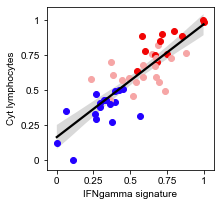

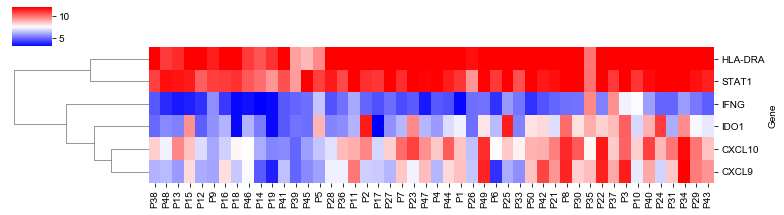

CXCL10 1.7207580987192674
CXCL9 2.0412944916014895
HLA-DRA 1.9312276569658593
IDO1 2.08478886370034
IFNG 1.3438600912554786
STAT1 0.8944274372139119


In [59]:
fig = plt.figure(figsize=(11, 1))
g = sns.heatmap(enrichment_IFNg.T[samples_order],
                       cmap="bwr",vmin=0,vmax=1,
                       xticklabels=enrichment_IFNg.columns)
plt.show()

fig = plt.figure(figsize=(4,3))
data = []
labels = []
for cluster in ['low','intermediate','high']:
    samples = [s for s,c in sample_clustNAME.items() if c == cluster]
    data.append(enrichment_IFNg.T[samples].values[0])
    labels.append(cluster+' n=('+str(len(samples))+')')
bplot = plt.boxplot(data,patch_artist=True)
colors = ['#2301FF', '#F6A6A6', '#F10505']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for element in [ 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='black')    
    
cold = data[0]
hot = list(data[1])
hot.extend(list(data[2]))
print('T-test results: low vs intermediate',ttest_ind(cold,data[1]))
print('T-test results: intermediate vs high',ttest_ind(data[1],data[2]))
print('T-test results: low vs intermediate+high',ttest_ind(cold,hot))

plt.xticks([1,2,3],labels)
plt.tight_layout()
plt.show()

enrichment['Immune cluster'] = enrichment['Sample ID'].apply(lambda x:sample_clustNAME[x])

fig,ax = plt.subplots(figsize=(3,3))
sns.regplot(enrichment['IFNgamma signature'],enrichment['Cyt lymphocytes'],scatter=False,color='black')
colors = {'low':'#2301FF', 'intermediate':'#F6A6A6', 'high':'#F10505'}
for row in enrichment.to_dict(orient='records'):
    plt.scatter(row['IFNgamma signature'],row['Cyt lymphocytes'],color=colors[row['Immune cluster']])
plt.xticks([0,0.25,0.5,0.75,1],[0,0.25,0.5,0.75,1])
plt.yticks([0,0.25,0.5,0.75,1],[0,0.25,0.5,0.75,1])

r,p = pearsonr(enrichment['IFNgamma signature'],enrichment['Cyt lymphocytes'])
print('Pearson correlation results: IFNgamma vs Cyt lymphocytes','R2',r,'P-value',p)
plt.show()


ifng_genes = ['IDO1','CXCL10','CXCL9','HLA-DRA','STAT1','IFNG']
exp_sel = exp[exp['Gene'].isin(ifng_genes)].set_index('Gene')
sns.clustermap(exp_sel[samples_order],cmap='bwr',vmax=12,col_cluster=False,figsize=(11, 3),xticklabels=True)
plt.savefig('heat.svg')
plt.show()
for row in exp_sel.reset_index().to_dict(orient='records'):
    vals = [ row[c] for c in exp_sel.columns]
    print(row['Gene'],np.std(vals))

### PanCancer Immune Nanostring panel: cancer type - immune cluster distribution

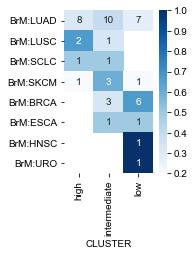

In [10]:
ctype_samps = {ctype:len(ctypedf) for ctype,ctypedf in enrichment.groupby('Cancer type')}

vals = []
valsn = []
for cluster, clusterdf in enrichment.groupby('Immune cluster'):
    clustern = float(len(clusterdf))
    d = {}
    dn = {}
    for ctype,ctypedf in clusterdf.groupby('Cancer type'):
        data = [
            [len(ctypedf), ctype_samps[ctype]-len(ctypedf)    ], #In cancer type
            [clustern-len(ctypedf),  len(enrichment)-ctype_samps[ctype]- clustern ]  #Not from cancer type
             ]
        f,p = fisher_exact(data)
        if p < 0.05:
            print('Significant enrichment of cancer type',ctype, 'in cluster', cluster, 'Odds ratio',f,'P-value',p)
        d[ctype] = len(ctypedf)/float(ctype_samps[ctype])
        dn[ctype] = len(ctypedf)
        
    d['CLUSTER'] = cluster
    dn['CLUSTER'] = cluster
    vals.append(d)  
    valsn.append(dn)  

df = pd.DataFrame(vals).set_index('CLUSTER')
dfn = pd.DataFrame(valsn).set_index('CLUSTER')

fig,ax = plt.subplots(figsize=(2,3))
sns.heatmap(df.T,cmap='Blues',annot=dfn.T)
plt.show()

# Cyt cells/IFNgamma signature enrichment vs CD8 IHC

In [11]:
def gen_figs_IHC(datadf,ihcv):
    fig = plt.figure(figsize=(4,3))
    data = []
    labels = []
    for cluster in ['low','int','high']:
        clusterdf  = datadf[datadf['Immune cluster']==cluster]
        data.append(clusterdf[ihcv].values)
        labels.append(cluster)
    colors = ['#2301FF', '#F6A6A6', '#F10505']
    cold = data[0]
    hot = list(data[1])
    hot.extend(list(data[2]))

    fig,ax = plt.subplots(figsize=(3,3))
    sns.regplot(datadf[ihcv],datadf['IFNgamma signature'],color='black')
    r,p = pearsonr(datadf[ihcv],datadf['IFNgamma signature'])
    print('Pearson correlation results: IFNgamma vs log2 CD8 IHC','R2',r,'P-value',p)
    plt.show()

    fig,ax = plt.subplots(figsize=(3,3))
    sns.regplot(datadf[ihcv],datadf['Cyt cells'],color='black')
    r,p = pearsonr(datadf[ihcv],datadf['Cyt cells'])
    print('Pearson correlation results: Cyt cells vs  vs log2 CD8 IHC','R2',r,'P-value',p)

    plt.show()
    return

Pearson correlation results: IFNgamma vs log2 CD8 IHC R2 0.5537723819030504 P-value 0.0001726981179996311


<Figure size 288x216 with 0 Axes>

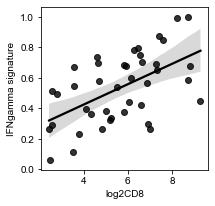

Pearson correlation results: Cyt cells vs  vs log2 CD8 IHC R2 0.4807053320925852 P-value 0.0014665403652083051


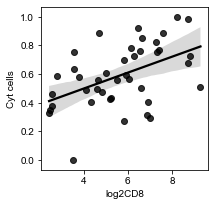

In [16]:
cd8['log2CD8'] = cd8['CD8 DENSITY (CELLS-mm2)'].apply(lambda x:np.log2(x))
cd8_nanostring = pd.merge(enrichment,cd8,on='Sample ID')
gen_figs_IHC(cd8_nanostring,'log2CD8')

## Patient survival based on immune cluster stratification

In [17]:
def compute_days(row):
    dx = row['BrM diagnosis(date)'].date()
    if row['Vital status'].lower() == 'dead': 
        act = row['Exitus (date)'].date()
        row['VITAL_STATUS_BOOL'] = 1
    else:
        row['VITAL_STATUS_BOOL'] = 0
        act = row['Last checkup (date)'].date()
    row['DAYS'] = (act-dx).days
    return row

In [18]:
clinical_annot = pd.merge(sample_annot,enrichment,on='Sample ID')
clinical_annot = clinical_annot[clinical_annot['Date known']==True]
clinical_annot = clinical_annot.apply(compute_days,axis=1)

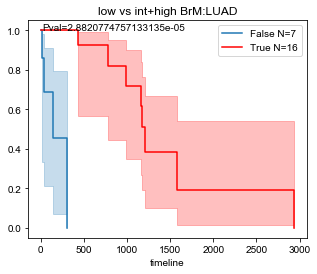

In [21]:
for primary, primarydf in clinical_annot.groupby('Cancer type_x'):
    primarydf['EXPRESSED'] = (primarydf['Immune cluster'].isin(['high','intermediate']))#&(survival_exp['Treg']>=p752)
    T = primarydf['DAYS'].apply(lambda x:int(x))
    E = primarydf['VITAL_STATUS_BOOL'].apply(lambda x:int(x))
    kmf = KaplanMeierFitter()
    groups = primarydf['EXPRESSED']

    results = logrank_test( T[(groups == True)], T[(groups == False)], 
               event_observed_A=E[(groups ==True)], 
               event_observed_B=E[(groups == False)])
    if results.p_value < 0.05 and len(E[(groups ==True)]) >=5 and len(E[(groups ==True)]) >=5:
        i = 0 
        for group in set(groups):    
            kmf.fit(T[(groups == group)], E[(groups == group)], label=str(group)+' N='+str(len(T[(groups == group)])))
            if i ==0:
                ax = kmf.plot(figsize=(5,4))
            else:
                kmf.plot(ax=ax,color='red')
            i+=1
        plt.title('low vs int+high '+primary)
        text = 'Pval='+str(results.p_value)
        ax.text(min(T),1,text,ha="left")    
        plt.show()
    else:
        continue

# Cyt cells/IFNgamma signature enrichment vs TMB

In [22]:
totalMB = 47  #Mb defined based capture kit size: Nimblegen SeqCap EZ MedExome + mtDNA

In [25]:
nsynmuts = ['Missense', 'InFrameDeletion', 'Frameshift', 'SpliceAcceptorSNV',
       'Nonsense', 'SpliceAcceptorDeletion',
       'CdsStopSNV', 'SpliceAcceptorInsertion',
       'CdsStartSNV', 'SpliceDonorSNV', 'InFrameInsertion',
       'SpliceDonorDeletion', 'MultiAAMissense', 'SpliceDonorInsertion',
       'CdsStartDeletion']
sign_d = {}
for sign in ['IFNgamma signature','Cyt cells']:
    sign_d[sign] = {}
    for row in enrichment.to_dict(orient='records'):
        sign_d[sign][row['Sample ID'].split('_')[0]] = row[sign]

P1 182 3.872340425531915
P12 396 8.425531914893616
P3 1790 38.08510638297872
P6 52 1.1063829787234043
P7 408 8.680851063829786
P9 326 6.9361702127659575


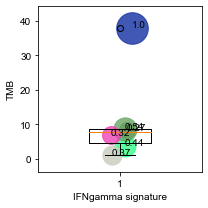

P1 182 3.872340425531915
P12 396 8.425531914893616
P3 1790 38.08510638297872
P6 52 1.1063829787234043
P7 408 8.680851063829786
P9 326 6.9361702127659575


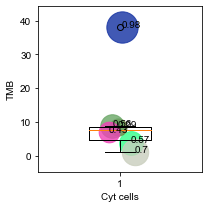

In [26]:
allmutsCGI_ns = wes[(wes['Mutation consequence type (CGI)'].isin(nsynmuts))
                    &(wes['Driver statement (CGI)']!='polymorphism')]
for sign in ['IFNgamma signature','Cyt cells']:
    data = [[],[]]
    samples_l = []
    for sample,sampledf in allmutsCGI_ns.groupby('Sample ID'):
        print(sample,len(sampledf),len(sampledf)/float(totalMB))
        data[0].append(len(sampledf)/float(totalMB))
        data[1].append(sign_d[sign][sample])
        samples_l.append(sample)

    fig, ax = plt.subplots(figsize=(3,3))
    x = np.random.normal(1, 0.04, size=len(samples_l))
    plt.boxplot(data[0])
    for i,s in enumerate(samples_l):
        plt.scatter(x[i],data[0][i],color=sample_colors[samples_l[i]],label=samples_l[i],s=data[1][i]*1000,alpha=0.8)
        plt.text(x[i],data[0][i],s=str(np.round(data[1][i],2)))

    plt.ylabel('TMB')
    plt.xlim(0.8,1.2)
    plt.xlabel(sign)
    plt.tight_layout()
    plt.show()  

# Flow Cytometry vs Nanostring

In [27]:
denom = ' (inside alive)'
mapping = {'CD8'+denom:['Cyt cells','IFNgamma signature']}
fc = fc[fc['Sample type']!='CSF']
enrichment_fc = pd.merge(fc,enrichment,on='Sample ID')

Spearman correlation  CD8 (inside alive)  vs  Cyt cells enrichment tau= 0.23076923076923073  P-value= 0.2629431403593601
Spearman correlation  CD8 (inside alive)  vs  IFNgamma signature enrichment tau= 0.3846153846153845  P-value= 0.07432891414402144


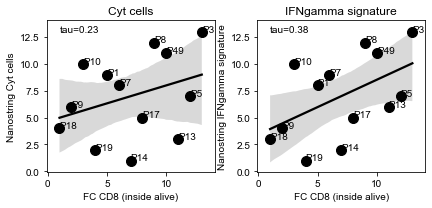

In [31]:

ncol=0
fig, ax = plt.subplots(ncols=2,figsize=(6,3))
corrs = []
for popFC,popNANOl in mapping.items():
    for popNANO in popNANOl:
        x = rankdata(enrichment_fc[popFC])
        y = rankdata(enrichment_fc[popNANO])
        samples = enrichment_fc['Sample ID'].tolist()
        tau,p = kendalltau(x,y)
        r,p = pearsonr(x,y)
        print('Spearman correlation ',popFC,' vs ',popNANO,'enrichment tau=',tau,' P-value=',p)
        sns.regplot(x,y,color='black',ax=ax[ncol])
        plt.sca(ax[ncol])
        for i,xx in enumerate(x):
            plt.scatter(xx,y[i],label=samples[i],s=100,color='black')
            plt.text(xx,y[i],samples[i])
        plt.title(popNANO)
        plt.text(min(x),max(y),'tau='+str(np.round(tau,2)))
        plt.xlabel('FC '+popFC)
        plt.ylabel('Nanostring '+popNANO)
        ncol+=1

plt.tight_layout()
plt.show()